In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import time
import sys
import pytorch_model_summary
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


print(f'torch : {torch.__version__}')
print(f'python : {sys.version}')

torch : 1.11.0
python : 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]


In [33]:

class ImageData(Dataset):
    def __init__(self,path,transform=None,target_transform=None):
        self.path = path
        self.files =[]
        self.labels = []
        for i in os.listdir(path):
            if i[:-3]+'png' in os.listdir(path+'/label'):
                self.files.append(i)
                self.labels.append(i[:-3]+'png')
        self.transform = transform
        self.target_transform = target_transform
        self.to_tensor = transforms.ToTensor()
        
    def __getitem__(self,idx):
        img = Image.open(self.path+'/'+self.files[idx])
        label = Image.open(self.path+'/label/'+self.labels[idx])
        #img = np.array(img)[:,:256]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            label = self.target_transform(label)
        return img, label

    def __len__(self):
        return len(self.files)

class ConvertToBackground(object):
    def __call__(self, img):
        img = np.asarray(img,dtype=np.uint8)
        img[img==255] = 0
        # 64bit 부호 정수 long 타입 Tensor로 변환 
        img = torch.from_numpy(img).long()
        return img


In [34]:
data_mean = [0.485, 0.456, 0.406]
data_std = [0.229, 0.224, 0.225]

transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        #transforms.RandomCrop((224,224)),
        #transforms.RandomAffine(degrees=15),
        # PIL 타입의 [0,255] data를 [0,1]의 FloatTensor로 변환
        transforms.ToTensor(),
        transforms.Normalize(mean=data_mean,std=data_std)
    ]
)
val_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=data_mean,std=data_std)
    ]
)
label_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        # 경계를 배경으로 처리
        ConvertToBackground()
    ]
)

batch_size = 4
train_path = './data/train'
train_set = ImageData(train_path,transform,label_transform)
#train_set = torchvision.datasets.VOCSegmentation(root='./data', year='2012',\
#    image_set='train',download=False,transform=transform,target_transform=label_transform)
train_loader = DataLoader(train_set, batch_size= batch_size,shuffle=True)
val_path = './data/val'
val_set = ImageData(val_path,val_transform,label_transform)
#val_set = torchvision.datasets.VOCSegmentation(root='./data', year='2012',\
#    image_set='val',download=False,transform=transform,target_transform=label_transform)
val_loader = DataLoader(val_set, batch_size= batch_size,shuffle=True)


In [35]:
#a,b = train_set[0]
#print(a.shape)

print(len(train_loader))
#temp_img,temp_label = next(iter(train_loader))
#print(temp_img)

366


In [36]:
# 사전에 학습된 vgg16 parameter 가져오기
vgg19 = torchvision.models.vgg19(pretrained=True)
for param in vgg19.features.parameters():
   param.requires_grad = False
print(vgg19.features[:-9])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [37]:
class FCN16(nn.Module):
    # vgg 19 
    def __init__(self,num_class):
        super(FCN16, self).__init__()
        self.vgg19 = vgg19.features

        self.fc1 = nn.Conv2d(in_channels=512,out_channels=4096,kernel_size=7)
        self.fc2 = nn.Conv2d(4096,4096,1)
        self.fc3 = nn.Conv2d(4096,num_class,1)
        self.pool4_conv = nn.Conv2d(512,21,1)

        self.upsample32 = nn.ConvTranspose2d(in_channels=num_class,out_channels=num_class,kernel_size=224,stride=32)
        self.upsample2 = nn.ConvTranspose2d(num_class,num_class,14,2)
        self.upsample16 = nn.ConvTranspose2d(num_class,num_class,16,16)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, num_class, kernel_size=1)
        self.relu    = nn.ReLU(inplace=True)

    def forward(self, x):
        pool4 = self.vgg19[:-9](x)
        pool5 = self.vgg19[-9:](pool4)

        #pool5 = self.fc1(pool5)
        #pool5 = nn.ReLU()(pool5)
        #pool5 = self.fc2(pool5)
        #pool5 = nn.ReLU()(pool5)
        #pool5 = self.fc3(pool5)
        #pool5 = self.upsample2(pool5)
        #pool4 = self.pool4_conv(pool4)
        #x = pool5 + pool4
        #x = self.upsample16(x)
        #print(pool5.shape)
        #print(pool4.shape)
        
        pool5 = self.deconv1(pool5)
        #print(pool5.shape)
        #print(pool4.shape)
        x = pool5 + pool4
        x = self.relu(self.deconv2(x))
        x = self.bn2(x)
        x = self.relu(self.deconv3(x))
        x = self.bn3(x)
        x = self.relu(self.deconv4(x))
        x = self.bn4(x)
        x = self.relu(self.deconv5(x))
        x = self.bn5(x)
        x = self.classifier(x)
        #print(x.shape)
        #print(x.shape)
        #x = self.upsample16(x)
        #print(x.shape)
        return x

    def make_block(self, in_channel, out_channel, repeat):
        layers = []
        for i in range(repeat):
            if (i==0):
                layers.append(nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, stride=1))
            else:
                layers.append(nn.Conv2d(out_channel,out_channel,kernel_size=3, padding=1, stride=1))
            layers.append(nn.BatchNorm2d(out_channel))
            layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        block = nn.Sequential(*layers)

        return block

In [38]:
FCN =FCN16(num_class=21)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
#print(FCN)
print(pytorch_model_summary.summary(FCN,torch.zeros(batch_size,3,224,224),show_input=True))

Using cuda device
-----------------------------------------------------------------------------
         Layer (type)            Input Shape         Param #     Tr. Param #
             Conv2d-1       [4, 3, 224, 224]           1,792               0
               ReLU-2      [4, 64, 224, 224]               0               0
             Conv2d-3      [4, 64, 224, 224]          36,928               0
               ReLU-4      [4, 64, 224, 224]               0               0
          MaxPool2d-5      [4, 64, 224, 224]               0               0
             Conv2d-6      [4, 64, 112, 112]          73,856               0
               ReLU-7     [4, 128, 112, 112]               0               0
             Conv2d-8     [4, 128, 112, 112]         147,584               0
               ReLU-9     [4, 128, 112, 112]               0               0
         MaxPool2d-10     [4, 128, 112, 112]               0               0
            Conv2d-11       [4, 128, 56, 56]         295,

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(FCN.parameters(), lr=0.0001)

In [40]:
def pixel_accuracy(output, label):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1),dim=1)
        correct = torch.eq(output, label).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy
# https://sanghyu.tistory.com/3 -- view, contiguous
def mIoU(output, label,num_classes=21):
    with torch.no_grad():
        output = F.softmax(output, dim=1)
        output = torch.argmax(output, dim=1)
        # 메모리에 저장된 순서를 하나씩, view할때 섞이지 않도록
        output = output.contiguous().view(-1)
        label = label.contiguous().view(-1)
    
        iou_class = []
        for c in range(0, num_classes):
            output_true = output==c
            label_true = label==c

            if label_true.long().sum().item() == 0:
                iou_class.append(np.nan)
            else:
                intersect = torch.logical_and(output_true,label_true).sum().float().item()
                union = torch.logical_or(output_true,label_true).sum().float().item()
                iou= intersect/union
                iou_class.append(iou)
        return np.nanmean(iou_class)

def get_lr(optim):
    for param_group in optim.param_groups:
        return param_group['lr']

In [41]:
# 학습
FCN.to(device)
epochs= 100
best_loss = 0
train_loss_list = []
train_acc_list = []
train_iou_list = []
val_loss_list = []
val_acc_list = []
val_iou_list = []
min_loss = np.inf
stop_count = 0
lrs = []
for epoch in range(epochs):
    val_running_loss = 0
    train_running_loss =0
    start_time = time.time()
    train_iou_score = 0
    val_iou_score =0
    train_acc = 0
    val_acc = 0

    FCN.train()
    for iter,data in tqdm(enumerate(train_loader)):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = FCN(inputs)
        # print(f'input shape : {inputs.shape}')
        # print(f'output shape : {outputs[0][0].shape}')
        # print(f'output  --{outputs[0][0]}')
        # print(f'labels shape : {labels.shape}')
        # print(f'lable --{labels[labels>0]}')
        loss = criterion(outputs,labels) 
        loss.backward()
        optimizer.step()

        train_iou_score += mIoU(outputs, labels)
        train_acc += pixel_accuracy(outputs, labels)
        train_running_loss += loss.item()
    
    FCN.eval()
    with torch.no_grad():
        for iter, vdata in tqdm(enumerate(val_loader)):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)

            voutputs = FCN(vinputs)
            vloss = criterion(voutputs,vlabels)

            val_running_loss += vloss.item()
            val_iou_score += mIoU(voutputs,vlabels)
            val_acc += pixel_accuracy(voutputs,vlabels)


        train_running_loss /= len(train_loader)
        train_iou_score /=len(train_loader)
        train_acc /=len(train_loader)
        val_running_loss /= len(val_loader)
        val_iou_score /=len(val_loader)
        val_acc /=len(val_loader)
        lrs.append(get_lr(optimizer))

        print(f'{epoch+1} epcoh , time = {time.time()-start_time:.2f}')
        print(f'train loss : {train_running_loss:.5f}, val_loss : {val_running_loss:.5f}')
        print(f'train IoU : {train_iou_score:.5f}, val IoU : {val_iou_score:.5f}')
        print(f'train Acc : {train_acc:.5f}, val Acc : {val_acc:.5f}')
        train_loss_list.append(train_running_loss)
        train_iou_list.append(train_iou_score)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_running_loss)
        val_iou_list.append(val_iou_score)
        val_acc_list.append(val_acc)

        if min_loss < val_running_loss:
            #min_loss = val_running_loss
            stop_count +=1
            if stop_count == 5:
                print('Stop loss not decrease')

                break
        elif min_loss > val_running_loss:
            min_loss = val_running_loss
            stop_count = 0
            #print('save model')
            torch.save(FCN, './models/FCN16-Vgg19_up.pt') 
            
                   
history = {'train_loss': train_loss_list, 'val_loss':val_loss_list,'train_miou': train_iou_list,
'val_miou':val_iou_list,'train_acc':train_acc_list,'val_acc':val_acc_list, 'lr':lrs}
print('Finish Training')

366it [00:22, 16.44it/s]
363it [00:21, 17.27it/s]


1 epcoh , time = 43.29
train loss : 2.37345, val_loss : 2.14374
train IoU : 0.15967, val IoU : 0.19124
train Acc : 0.59047, val Acc : 0.71302


366it [00:21, 17.36it/s]
363it [00:20, 17.82it/s]


2 epcoh , time = 41.46
train loss : 1.74619, val_loss : 1.41043
train IoU : 0.21665, val IoU : 0.23967
train Acc : 0.74797, val Acc : 0.78161


366it [00:20, 17.49it/s]
363it [00:20, 17.58it/s]


3 epcoh , time = 41.58
train loss : 1.41890, val_loss : 1.17468
train IoU : 0.23789, val IoU : 0.23896
train Acc : 0.77421, val Acc : 0.78859


366it [00:21, 16.95it/s]
363it [00:21, 17.28it/s]


4 epcoh , time = 42.60
train loss : 1.22036, val_loss : 1.05049
train IoU : 0.25166, val IoU : 0.26369
train Acc : 0.78567, val Acc : 0.79776


366it [00:21, 16.69it/s]
363it [00:20, 17.72it/s]


5 epcoh , time = 42.42
train loss : 1.07157, val_loss : 0.97131
train IoU : 0.27083, val IoU : 0.27597
train Acc : 0.79571, val Acc : 0.80234


366it [00:20, 17.47it/s]
363it [00:20, 17.97it/s]


6 epcoh , time = 41.16
train loss : 0.96960, val_loss : 0.86665
train IoU : 0.28224, val IoU : 0.30094
train Acc : 0.80344, val Acc : 0.81321


366it [00:21, 17.25it/s]
363it [00:20, 18.01it/s]


7 epcoh , time = 41.38
train loss : 0.88330, val_loss : 0.83454
train IoU : 0.30460, val IoU : 0.32193
train Acc : 0.81220, val Acc : 0.81927


366it [00:20, 17.56it/s]
363it [00:20, 17.98it/s]


8 epcoh , time = 41.03
train loss : 0.80278, val_loss : 0.78075
train IoU : 0.33677, val IoU : 0.35080
train Acc : 0.82397, val Acc : 0.82713


366it [00:21, 17.37it/s]
363it [00:20, 18.05it/s]


9 epcoh , time = 41.19
train loss : 0.73733, val_loss : 0.78816
train IoU : 0.36188, val IoU : 0.36342
train Acc : 0.83303, val Acc : 0.82694


366it [00:21, 17.30it/s]
363it [00:20, 17.98it/s]


10 epcoh , time = 41.35
train loss : 0.66149, val_loss : 0.71975
train IoU : 0.39907, val IoU : 0.37129
train Acc : 0.84512, val Acc : 0.83376


366it [00:21, 17.20it/s]
363it [00:20, 17.70it/s]


11 epcoh , time = 41.80
train loss : 0.62727, val_loss : 0.68910
train IoU : 0.42719, val IoU : 0.39160
train Acc : 0.85345, val Acc : 0.83597


366it [00:21, 17.09it/s]
363it [00:20, 17.57it/s]


12 epcoh , time = 42.08
train loss : 0.56522, val_loss : 0.68530
train IoU : 0.45594, val IoU : 0.42609
train Acc : 0.86408, val Acc : 0.84070


366it [00:20, 17.45it/s]
363it [00:20, 17.87it/s]


13 epcoh , time = 41.29
train loss : 0.51510, val_loss : 0.67369
train IoU : 0.48849, val IoU : 0.42505
train Acc : 0.87618, val Acc : 0.84550


366it [00:21, 16.84it/s]
363it [00:21, 16.72it/s]


14 epcoh , time = 43.46
train loss : 0.46900, val_loss : 0.65419
train IoU : 0.51702, val IoU : 0.41893
train Acc : 0.88438, val Acc : 0.84248


366it [00:22, 16.40it/s]
363it [00:21, 17.17it/s]


15 epcoh , time = 43.46
train loss : 0.42770, val_loss : 0.65783
train IoU : 0.54407, val IoU : 0.43874
train Acc : 0.89355, val Acc : 0.84426


366it [00:21, 16.71it/s]
363it [00:21, 17.22it/s]


16 epcoh , time = 42.99
train loss : 0.39782, val_loss : 0.64869
train IoU : 0.56311, val IoU : 0.45172
train Acc : 0.89987, val Acc : 0.84709


366it [00:22, 16.08it/s]
363it [00:20, 17.93it/s]


17 epcoh , time = 43.02
train loss : 0.36038, val_loss : 0.63665
train IoU : 0.59086, val IoU : 0.45727
train Acc : 0.90849, val Acc : 0.84727


366it [00:22, 16.22it/s]
363it [00:21, 16.82it/s]


18 epcoh , time = 44.16
train loss : 0.32382, val_loss : 0.64621
train IoU : 0.61539, val IoU : 0.45783
train Acc : 0.91707, val Acc : 0.84720


366it [00:22, 16.41it/s]
363it [00:20, 17.39it/s]


19 epcoh , time = 43.19
train loss : 0.30021, val_loss : 0.64459
train IoU : 0.63552, val IoU : 0.46697
train Acc : 0.92272, val Acc : 0.84980


366it [00:21, 16.95it/s]
363it [00:20, 17.73it/s]


20 epcoh , time = 42.08
train loss : 0.27993, val_loss : 0.64297
train IoU : 0.65126, val IoU : 0.46398
train Acc : 0.92723, val Acc : 0.84695


366it [00:21, 17.14it/s]
363it [00:20, 17.46it/s]


21 epcoh , time = 42.15
train loss : 0.25889, val_loss : 0.64091
train IoU : 0.66681, val IoU : 0.44595
train Acc : 0.93222, val Acc : 0.84554


366it [00:21, 17.08it/s]
363it [00:21, 16.89it/s]


22 epcoh , time = 42.93
train loss : 0.23220, val_loss : 0.61683
train IoU : 0.68772, val IoU : 0.46504
train Acc : 0.93910, val Acc : 0.84932


366it [00:21, 16.98it/s]
363it [00:20, 17.82it/s]


23 epcoh , time = 41.93
train loss : 0.21604, val_loss : 0.62327
train IoU : 0.69811, val IoU : 0.46596
train Acc : 0.94318, val Acc : 0.84648


366it [00:21, 16.64it/s]
363it [00:21, 16.86it/s]


24 epcoh , time = 43.52
train loss : 0.19877, val_loss : 0.64153
train IoU : 0.72178, val IoU : 0.46788
train Acc : 0.94765, val Acc : 0.84835


366it [00:21, 17.00it/s]
363it [00:20, 17.37it/s]


25 epcoh , time = 42.43
train loss : 0.19114, val_loss : 0.65486
train IoU : 0.72866, val IoU : 0.45703
train Acc : 0.94985, val Acc : 0.84755


366it [00:21, 17.39it/s]
363it [00:20, 17.90it/s]


26 epcoh , time = 41.33
train loss : 0.17312, val_loss : 0.63936
train IoU : 0.74732, val IoU : 0.45773
train Acc : 0.95445, val Acc : 0.84639


366it [00:20, 17.52it/s]
363it [00:20, 17.42it/s]

27 epcoh , time = 41.73
train loss : 0.15902, val_loss : 0.66889
train IoU : 0.75545, val IoU : 0.47014
train Acc : 0.95750, val Acc : 0.84593
Stop loss not decrease
Finish Training


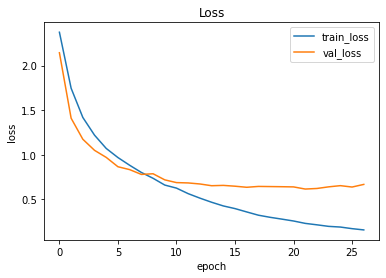

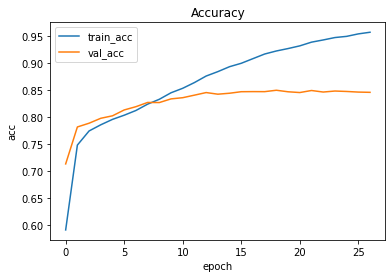

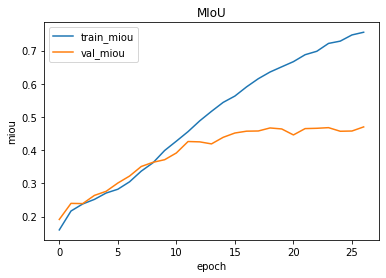

In [42]:
history = {'train_loss': train_loss_list, 'val_loss':val_loss_list,'train_miou': train_iou_list,
'val_miou':val_iou_list,'train_acc':train_acc_list,'val_acc':val_acc_list,'lr':lrs}
def plot_loss(history):
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

def plot_miou(history):
    plt.plot(history['train_miou'], label='train_miou')
    plt.plot(history['val_miou'], label='val_miou')
    plt.title('MIoU')
    plt.xlabel('epoch')
    plt.ylabel('miou')
    plt.legend()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_acc')
    plt.plot(history['val_acc'], label='val_acc')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.show()
plot_loss(history)
plot_acc(history)
plot_miou(history)

In [43]:
print(history['lr'])

[0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]


torch.Size([4, 3, 224, 224])
torch.Size([4, 21, 224, 224])
torch.Size([4, 224, 224])


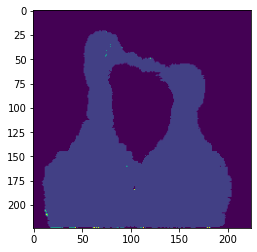

In [44]:
a, b= train_set[0]
FCN.eval()
with torch.no_grad():
    for i, data in enumerate(train_loader):
        a, b = data
        FCN.to(device)
        print(a.shape)
        a = a.to(device)
        c = FCN(a)
        break

print(c.shape)
mask = torch.argmax(c, dim=1)
print(mask.shape)
#print(c[0])
plt.imshow(mask[0].cpu())
# t = a.view(8,224,224,3)
# # t = t.view(224,224,3)
# plt.figure(figsize=(10,10))
# plt.subplot(1,3,1)
# plt.imshow(mask[0].cpu())
# plt.subplot(1,3,2)
# plt.imshow(b[0].cpu())
# plt.subplot(1,3,3)
# plt.imshow(t[0].cpu())
